# Imports

In [1]:
# System
import sys

# Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt

# math and array tools 
import numpy as np
import pandas as pd
from scipy import interpolate
import scipy.integrate as integrate
from scipy import optimize
from itertools import permutations

# Access local directories
import os, glob

# Timing
import time as t

# Plot controls

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

# Density Profiles

## Global Varibles

In [3]:
# unit conversions
hz_to_invpc = 1.029e8
s_to_pc = 9.716e-9
m_to_pc = 3.241e-17
solar_mass_to_pc = 4.8e-14
g_cm3_to_invpc2 = 7.072e8
year_to_pc = 0.3064

In [4]:
1e5 *solar_mass_to_pc

4.8e-09

## Generic Density Distribution

In [3]:
scale = {'a':0.01, 'rho0':0.3}
NFWparams = {'alpha':1,'beta':3,'gamma':1}
Hernquistparams = {'alpha':1,'beta':4,'gamma':1}

In [4]:
def rho_DM_general(r, **kwargs):
    a, rho0 = kwargs['a'], kwargs['rho0']
    alpha, beta, gamma = kwargs['alpha'], kwargs['beta'], kwargs['gamma']
    # x is dimensionless
    x = r/a
    
    rho = rho0*(x**(-gamma))*(1+(x**alpha))**((gamma-beta)/alpha)
    
    # convert to pc^-2
#     rho *= 1.264e-15 #[GeV/cm3 to pc-2]
    return rho

# Spike Density from Eda paper

In [6]:
def get_rsp(Mbh=1e3):
    # use equation M(<rh) = int_0^rh 4pi rho_dm(r)r^2 = 2M_bh from arxiv:1408.3534
    
    def f(rh):
        rsp = 0.2*rh
        LHS = integrate.quad(lambda r: 4*np.pi*(rho_spike(r, rsp=rsp)*2.938e64)*r**2, 0, rh)[0] # convert desnity to GeV/kpc^3
        RHS = 2*Mbh * 1.11543e57 # convert Msol to GeV/c^2
        return LHS-RHS
    
    rh = optimize.newton(f, 1e-3)
    return 0.2*rh # rsp 

def get_Rs(Mbh=1e3):
    G = 4.3e-3 *1e-3 # [kpc/Msol * (km/s)^2]
    c = 3e5 #[km/s]
    Rs = 2*G*Mbh / c**2
    return Rs

def rho_nfw(r, rhos=3.8e-22, rs=0.0231):
    x = r/rs
    rho = rhos / (x * (1+x)**2)
    # convert to GeV/cm^3 from g/cm^3
    rho *= 5.61e23
    return rho


def rho_spike(r, alpha_ini=1., rsp=0.54e-3):
    # rhosp in units Msol/pc^3
#     rhosp *= 37.96 #Msol/pc^3 to GeV/cm^3
    rhosp = rho_nfw(rsp)
    # alpha is dimensionless
    alpha = (9.-2.*alpha_ini)/(4.-alpha_ini)

    rho = rhosp * (rsp/r)**alpha
    
    Rs = get_Rs(Mbh=1e5)
    rho *= (1-4*(Rs/r))**3
    
    return np.where(r < rsp, rho, rho_nfw(r))

In [33]:
integrate.quad(lambda r: 4*np.pi*(rho_spike(r, rsp=rsp)*2.938e64)*r**2, 0, 1)

(2.7561325909941188e+63, 2.6820730490209236e+55)

In [34]:
rs

0.0047907321015407105

In [44]:
rsp = get_rsp(Mbh=1e5)
rsp

0.004790732101656293

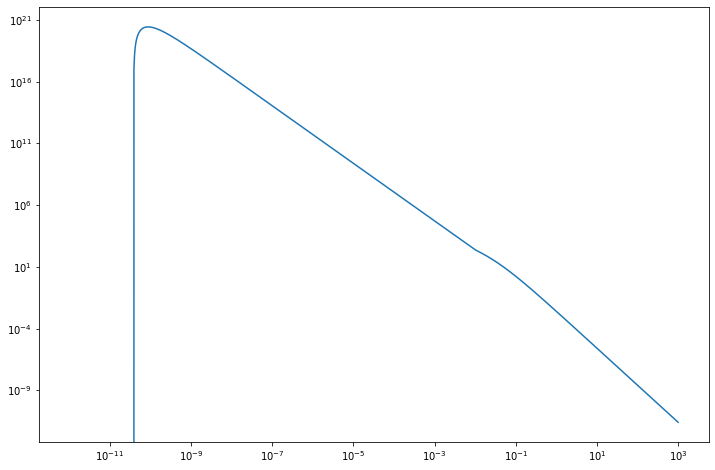

In [10]:
r_list = np.geomspace(1e-12,1e3,1000)

plt.loglog(r_list, rho_spike(r_list, rsp=10e-3))

## Effective Scaling GR Density

In [7]:
scaleparameters={
    #'a':0.01, #[kpc]
    #'a':20., #[kpc]
    #'rho0':0.3, #[GeV/cm^3]
    'a':0.231,
    'rho0':3.8e-22 * 5.61e23, #[g/cm^3 to GeV/cm^3],
    'Mbh':1e5 #[Msol]    
}
NFWparameters={
    'alpha':0.331,
    'beta':-1.66,
    'gamma':0.32,
    'delta':-0.000282
}
Hernparameters={
    'alpha':0.335,
    'beta':-1.67,
    'gamma':0.31,
    'delta':-0.025
}
NFWfit_newton={
    'eta':2,
    'A':1.60,
    'w':2.18,
    'q':1.98
}
NFWfit_rel={
    'eta':1,
    'A':6.42,
    'w':1.82,
    'q':1.91
}
Hernfit_newton={
    'eta':2,
    'A':4.87,
    'w':2.22,
    'q':1.93
}
Hernfit_rel={
    'eta':1,
    'A':7.90,
    'w':1.83,
    'q':1.90
}

In [11]:
def rho_effective(r, **kwargs):
    # scale params
    rho0, Mbh, a = kwargs['rho0'], kwargs['Mbh'], kwargs['a']
    # profile params
    alpha, beta, gamma, delta = kwargs['alpha'], kwargs['beta'], kwargs['gamma'], kwargs['delta']
    # fit params 
    A, w, q, eta= kwargs['A'], kwargs['w'], kwargs['q'], kwargs['eta']
   
    # convert units so rho_bar has units 1/pc^2 and x_tilde is unitless
    r *= 1e3 #[kpc to pc]
    A *= 1e-43 / solar_mass_to_pc /solar_mass_to_pc #[Msol^-2 to pc^-2: 1/2.29e-27]
    x_tilde = r / (Mbh * solar_mass_to_pc) # convert Mbh form Msol to pc
    
    rho_bar = A*(1.- 4.*eta / x_tilde)**w *(4.17*1e11/x_tilde)**q
    
    rho = rho_bar*(10**delta)*((rho0/0.3)**alpha)*((Mbh/1e6)**beta)*((a/20.)**gamma)
    
    rho*=7.934e14 # convert to GeV/cm^3 from 1/pc^2

    return rho

In [12]:
# rho effective takes a dictionary with scale params, profile params and fit params
rho_NFW_Newton_params = {**scaleparameters, **NFWparameters, **NFWfit_newton}

r = 0.1
print(rho_effective(r, **rho_NFW_Newton_params))
print(r)

2002.1145404493247
0.1


# Plotting and tests

## Comparing NFW and Hernquist

In [ ]:
# r_list = np.geomspace(1e-6,100,100)
r_list = np.geomspace(1e-11,1,10000)


NFWparams = {**scale,**NFWparams}
Hernparams = {**scale,**Hernquistparams}

rhoNFW = np.array([[r, rho_DM_general(r, **NFWparams)] for r in r_list])
rhoHern = np.array([[r, rho_DM_general(r, **Hernparams)] for r in r_list])

plt.loglog(np.log10(rhoNFW[:,0]/(9.608e-11)),np.log10(rhoNFW[:,1]), label='NFW')
plt.loglog(np.log10(rhoHern[:,0]/(9.608e-11)),np.log10(rhoHern[:,1]), label='Hernquist')
# plt.xscale('log')
plt.legend()

## Plotting Effective Scaling Density

## Figure 1 plot a

In [ ]:
# r is entered in kpc
r_list = np.geomspace(1e-11,1e3,100000)

rho_NFW_Newton_params = {**scaleparameters, **NFWparameters, **NFWfit_newton}
rho_NFW_rel_params = {**scaleparameters, **NFWparameters, **NFWfit_rel}

#take log after 
rhoNFW_Newton = np.array([[r, rho_effective(r, **rho_NFW_Newton_params)] for r in r_list])
rhoNFW_rel = np.array([[r, rho_effective(r, **rho_NFW_rel_params)] for r in r_list])


plt.plot(np.log10(rhoNFW_Newton[:,0]/(9.608e-11)),np.log10(rhoNFW_Newton[:,1]), label='NFW (Newtonian) Eqn.7')
plt.plot(np.log10(rhoNFW_rel[:,0]/(9.608e-11)),np.log10(rhoNFW_rel[:,1]), label='NFW (relativistic) Eqn.7')

#plt.loglog(rhoNFW[:,0],rhoNFW[:,1], label='NFW Eqn.1')
# plt.yscale('log')
# plt.xscale('log')
plt.xlim(0,7)
plt.ylim(10,20)
plt.legend()

## Figure 1 plot b

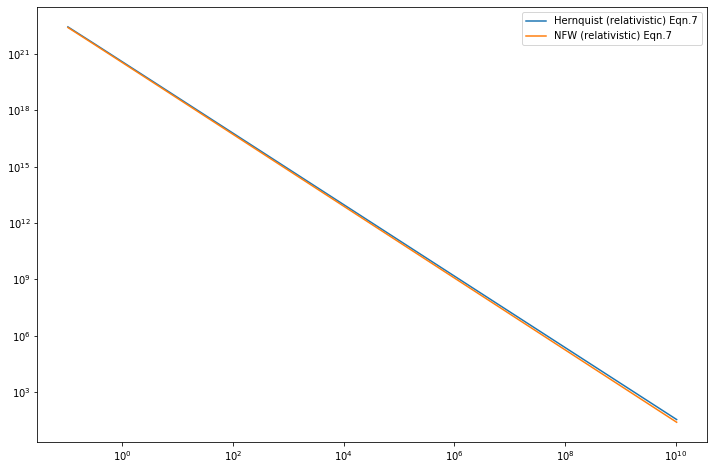

In [26]:
r_list = np.geomspace(1e-11,1,10000)
#r_list = np.log10(r_list/(9.608e-11))

rho_NFW_Hernquist_params = {**scaleparameters, **Hernparameters, **Hernfit_rel}
rho_NFW_rel_params = {**scaleparameters, **NFWparameters, **NFWfit_rel}

#take log after 
rhoHern_rel = np.array([[r, rho_effective(r, **rho_NFW_Hernquist_params)] for r in r_list])
rhoNFW_rel = np.array([[r, rho_effective(r, **rho_NFW_rel_params)] for r in r_list])


plt.loglog(rhoHern_rel[:,0]/(9.608e-11),rhoHern_rel[:,1], label='Hernquist (relativistic) Eqn.7')
plt.loglog(rhoNFW_rel[:,0]/(9.608e-11),rhoNFW_rel[:,1], label='NFW (relativistic) Eqn.7')
#plt.loglog(rhoNFW[:,0],rhoNFW[:,1], label='NFW Eqn.1')
# plt.yscale('log')
#plt.xscale('log')
# plt.xlim(-2,7)
# plt.ylim(10,25)
plt.legend()

## Rho spike from Eda paper

/Users/adamsmith/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


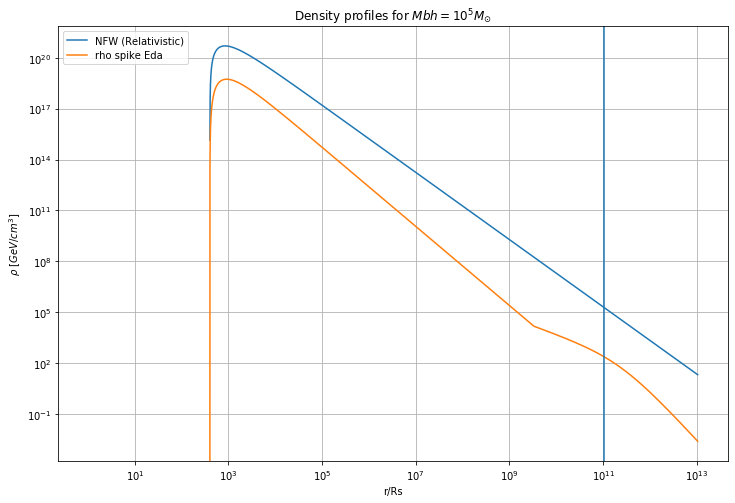

In [16]:
# r is entered in kpc
r_list = np.geomspace(1e-13,1,10000)

Rs = get_Rs(Mbh=1e3)
# Rs = 1

rho_NFW_rel_params = {**scaleparameters, **NFWparameters, **NFWfit_rel}
rhoNFW_Newton = np.array([[r/Rs, rho_effective(r, **rho_NFW_Newton_params)] for r in r_list])

rsp = get_rsp(Mbh=1e3)

plt.loglog((rhoNFW_Newton[:,0]), (rhoNFW_Newton[:,1]), label='NFW (Relativistic)')
plt.loglog(r_list/Rs, (rho_spike(r_list, rsp=rsp)), label='rho spike Eda')

plt.axvline(x=0.01/Rs)

plt.xlabel('r/Rs')
plt.ylabel(r'$\rho$ [$GeV/cm^3$]')
plt.title(r'Density profiles for $Mbh=10^5M_{\odot}$')
# plt.xlim(1e-1,1e11)
plt.legend(); plt.grid()

/Users/adamsmith/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


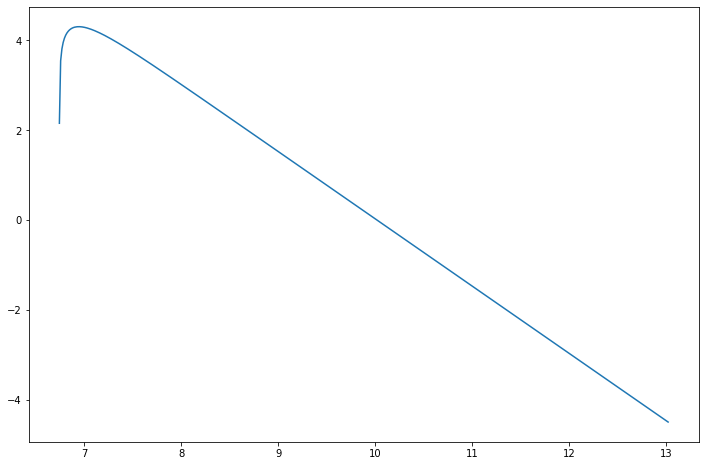

In [12]:
r = np.geomspace(1e-10, 1e3, 1000)
scale = 9.608e-11

plt.plot(np.log10(r/scale), np.log10(rho_GS(r)))

# GS and Eda Spike densities

In [ ]:
# r is in pc 
def rho_spike_eda(r, alpha_ini=1, rhosp=226, rsp=0.54):
    rhosp *= 37.96 # [Msol/pc^3] to [GeV/cm^3]
    alpha = (9-2*alpha_ini)/(4-alpha_ini)
    # compatability with arrays
    try:
        if r.ndim > 0:
            rho = np.array([rho_spike(r) for r in r])
            return rho
    except: pass

    rho = rhosp * (rsp/r)**alpha
    
    return rho if r < rsp else rho_nfw(r)

def rho_spike_gs(r, alpha_ini=1, rhosp=226, rsp=0.54):
    Mbh = 1e3 # [Msol]
    G = 4.3e-3 # [pc/Msol * (km/s)^2]
    c = 3e5 #[km/s]
    Rs = 2*G*Mbh / c**2
    
    rho0 = 3.8e-22 * 5.62e23 # g/cm^3 to GeV/cm^3 from Eda
    r0 = 23.1 # pc from Eda
    alpha = (9-2*alpha_ini)/(4-alpha_ini)
    rhoR = rho0*(rsp/r0)**(-alpha)
    
    def g_alpha(r):
        return (1-4*(Rs/r))**3
    
    rho = rhoR*g_alpha(r)*(rsp/r)**alpha
    
    return rho
    
    

In [ ]:
Gm = 4.3e-3 * 1e3 / 3e5**2

r = np.linspace(10e-11, 80*Gm, 100) /Gm

rho = np.array([rho_spike_gs(r) for r in r])
rhoeda = np.array([rho_spike_eda(r) for r in r])

plt.loglog(r, rho)
plt.loglog(r, rhoeda)

In [ ]:
Gm